# Tutorial on Physics Informed Neural Networks

**Presenter:** Ronit Das



## Introduction

What are PINNs?

- PINNs are Neural Networks used to learn a generic function $f$.
- Like standard NNs, PINNs account for observation data $\{ x_i \}_{i=1}^N$ in learning $f$.
- In addition, the optimization of $f$ is guided by a regularization term, which encourages $f$ to be the solution of a Partial Differential Equation (PDE).

### Traditional PDE solvers

- Simple problems can be solved analytically.
- E.g., consider the velocity:

$$v(t) = \frac{d x}{d t} = \lim_{h \rightarrow 0} \frac{x(t+h) - x(t)}{h}$$

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/simple_pde.png?raw=1" style="width: 40%; display: block; margin: auto;">

- Solution:

$$
v(t) =
\begin{cases}
3/2 & \text{if}\; t \in \{ 0, 2 \} \\
0 & \text{if}\; t \in \{ 2, 4 \} \\
-1/3 & \text{if}\; t \in \{ 4, 7 \}
\end{cases}
$$



- In most real-world problems solutions cannot be found analytically.
- Differential equations are solved numerically.
- E.g., they apply the definition of derivative for *all* the point of the time domain.

**Limitations of PDE solvers**

- Computationally expensive and scale bad to big data.
- Integrating external data sources (e.g., from sensors) is problematic.

## Neural Networks

<img src="https://github.com/FilippoMB/Physics-Informed-Neural-Networks-tutorial/blob/main/figs/hhgneural_net.png?raw=1" style="width: 40%; display: block; margin: auto;">

- Universal function approximators.
- Can consume any kind of data $\boldsymbol{X}$.
- Are trained to minimize a loss, e.g., the error between the predictions $\boldsymbol{\hat{y}}$ and the desired outputs $\boldsymbol{y}$.

In [1]:
# Imports
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm

Let's start by creating a simple neural network in <a href="https://pytorch.org"><b>PyTorch</b></a>.

In [2]:
# Define a simple neural network for regression

class simple_NN(nn.Module):
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 8),
            nn.Tanh(),
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 4),
            nn.Tanh(),
            nn.Linear(4, 1),
            #nn.Sigmoid()     --------------> uncomment for answering Question 2
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out

Then,
- Create a small dataset $\{x_i, y_i\}_{i=1, \dots 5}$.
- Use the NN to make predictions: $\hat{y}_i = \rm{NN}(x_i)$.
- Train the NN by minimizing $\rm{MSE}(\boldsymbol{y}, \boldsymbol{\hat{y}})$.

In [3]:
# Define dataset
x_train = torch.tensor([[1.1437e-04],
        [1.4676e-01],
        [3.0233e-01],
        [4.1702e-01],
        [7.2032e-01]], dtype=torch.float32)
y_train = torch.tensor([[1.0000],
        [1.0141],
        [1.0456],
        [1.0753],
        [1.1565]], dtype=torch.float32)

In [4]:
# Initialize the model
model = simple_NN()

# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

EPOCHS = 1000

# Train
for ep in range(EPOCHS):

    # Compute prediction error
    pred = model(x_train)
    loss = loss_fn(pred, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.244831
epoch: 200, loss: 0.000475
epoch: 400, loss: 0.000319
epoch: 600, loss: 0.000200
epoch: 800, loss: 0.000100


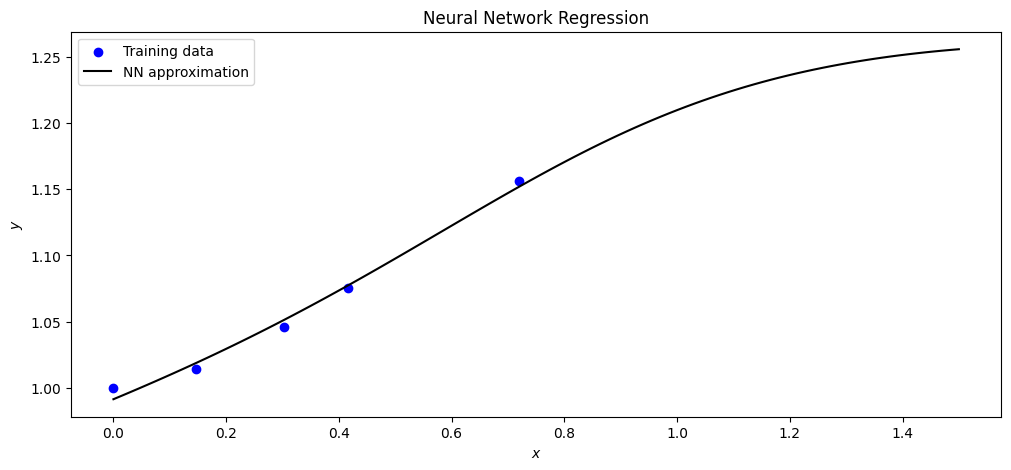

In [5]:
# evaluate the model on all data points in the domain
domain = [0.0, 1.5]
#domain = [0.0, 1.0]    ------------------> uncomment for answering question 2
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = model(x_eval)

# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Training data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.set(title="Neural Network Regression", xlabel="$x$", ylabel="$y$")
ax.legend();

- The NN does a good job in fitting the data samples.
- However, it has no information on what function should learn when $x>0.75$.

## Physics Informed NNs

- Use PDEs to adjust the NN output.
- Train the model with an additional loss that penalizes the violation of the PDE.

$$ \mathcal{L}_{\text{tot}} =  \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{PDE}}$$



**Advantages**

Combine information from both data and from physical models.
- Compared to traditional NNs, $\mathcal{L}_{\text{PDE}}$ regularizes the model limiting overfitting and improving generalization.
- Compared to traiditional PDE solvers, PINNs are more scalable and can consume any kind of data.

### Example I: population growth

Logistic equation for modeling the population growth:

$$ \frac{d f(t)}{d t} = Rt(1-t)$$

- $f(t)$ is the population growth over time $t$
- $R$ is the max growth rate
- To identify a solution, a boundary condition must be imposed, e.g., at $t=0$:

$$f(t=0)=1$$

In [6]:
R = 1.0
ft0 = 1.0

- Use the NN to model $f(t)$, i.e., $f(t) = \rm{NN}(t)$
- We can easily compute the derivative $\frac{d\rm{NN}(t)}{dt}$ thanks to automatic differentiation provided by deep learning libraries


In [7]:
def df(f: simple_NN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

- We want our NN to satisfy the following equation:

$$ \frac{d\rm{NN}(t)}{dt} - Rt(1-t) = 0 $$

- To do that, we add the following physics-informed regularization term to the loss:

$$ \mathcal{L}_\rm{PDE} = \frac{1}{N} \sum_{i=1}^N \left( \frac{d\rm{NN}}{dt} \bigg\rvert_{t_i} - R t_i (1-t_i) \right)^2 $$

- where $t_i$ are **collocation points**, i.e., a set of points from the domain where we evaluate the differential equation.

In [8]:
# Generate 10 evenly distributed collocation points
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

- Only minimizing $\mathcal{L}_\rm{PDE}$ does not ensure a unique solution.
- We must include the boundary condition by adding the following loss:

$$ \mathcal{L}_\rm{BC} = \left( \rm{NN}(t_0) - 1 \right)^2 $$

- This lets the NN converge to the desired solution among the infinite possible ones.

The final loss is given by:

$$ \mathcal{L}_\rm{PDE} + \mathcal{L}_\rm{BC} + \mathcal{L}_\rm{data} $$

In [9]:
# Wrap everything into a function
def compute_loss(nn: simple_NN,
                 t: torch.Tensor = None,
                 x: torch.Tensor = None,
                 y: torch.Tensor = None,
                 ) -> torch.float:
    """Compute the full loss function as pde loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    pde_loss = df(nn, t) - R * t * (1 - t)
    pde_loss = pde_loss.pow(2).mean()

    boundary = torch.Tensor([0.0])
    boundary.requires_grad = True
    bc_loss = nn(boundary) - ft0
    bc_loss = bc_loss.pow(2)

    mse_loss = torch.nn.MSELoss()(nn(x), y)

    tot_loss = pde_loss + bc_loss + mse_loss

    return tot_loss

In [11]:
model = simple_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

EPOCHS_2 = 2000

# Train
for ep in range(EPOCHS_2):

    loss = compute_loss(model, t, x_train, y_train)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 1.867165
epoch: 200, loss: 0.001326
epoch: 400, loss: 0.000745
epoch: 600, loss: 0.000458
epoch: 800, loss: 0.000234
epoch: 1000, loss: 0.000123
epoch: 1200, loss: 0.000101
epoch: 1400, loss: 0.000093
epoch: 1600, loss: 0.000088
epoch: 1800, loss: 0.000085


In [12]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=x_eval.squeeze().detach().numpy()
)

f_colloc = solve_ivp(
    logistic_eq_fn, domain, [ft0], t_eval=t.squeeze().detach().numpy()
).y.T

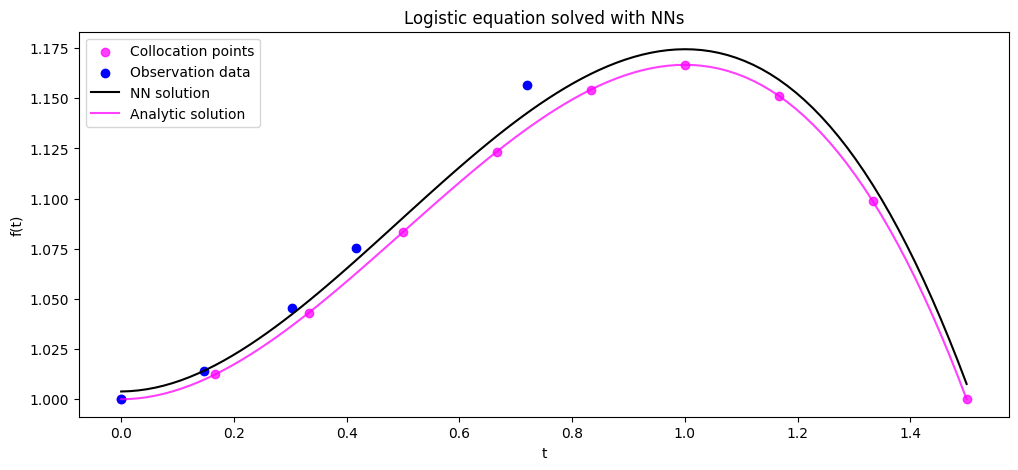

In [13]:
# evaluation on the domain [0, 1.5]
f_eval = model(x_eval)

# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Observation data", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN solution", color="black")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Analytic solution", color="magenta", alpha=0.75)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend();

### Questions

1. Play around this PINN with the following number of epochs:
  a. 500
  b. 1500
  c. 3000
  d. 5000
  What's your observation?

2. Try replacing the MSE Loss with other objective function. Let's say using the CrossEntropy Loss. You can replace "torch.nn.MSELoss()(nn(x), y)" with "torch.nn.CrossEntropyLoss()(nn(x), y)". What's your observation?
3. Comment out the MSE Loss only. Observe what you see with training only with the PDE and the BC Objective.

## References

[[1](https://www.sciencedirect.com/science/article/pii/S0021999118307125)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational physics 378 (2019): 686-707.

[[2](https://maziarraissi.github.io/PINNs/)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics Informed Deep Learning".

[[3](https://www.sciencedirect.com/science/article/pii/S095219762030292X)] Nascimento, R. G., Fricke, K., & Viana, F. A. (2020). A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network. Engineering Applications of Artificial Intelligence, 96, 103996.


[[5](https://towardsdatascience.com/physics-and-artificial-intelligence-introduction-to-physics-informed-neural-networks-24548438f2d5)] Paialunga Piero. "Physics and Artificial Intelligence: Introduction to Physics Informed Neural Networks".

